In [1]:
#do all the necessary imports 
import os
import nibabel as nib
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
from torch import nn
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch.optim as optim
from sklearn.metrics import roc_auc_score, f1_score
#check if a gpu exists
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



In [2]:
#load the dataset and perform resizing 
class LoadingData(Dataset):
    def __init__(self, volume_paths, segmentation_paths, target_shape=(64, 64, 64)):
        self.volume_paths = volume_paths
        self.segmentation_paths = segmentation_paths
        self.target_shape = target_shape
        
        assert len(self.volume_paths) == len(self.segmentation_paths), \
            "Number of volumes and segmentations do not match"
        
    def __len__(self):
        return len(self.volume_paths)
    
    def __getitem__(self, idx):
        volume_path = self.volume_paths[idx]
        volume = nib.load(volume_path).get_fdata()

        segmentation_path = self.segmentation_paths[idx]
        segmentation = nib.load(segmentation_path).get_fdata()

        volume = torch.FloatTensor(volume).float()
        segmentation = torch.FloatTensor(segmentation).float()  

        volume = F.interpolate(volume.unsqueeze(0).unsqueeze(0),
                               size=self.target_shape,
                               mode='trilinear',
                               align_corners=False).squeeze(0).squeeze(0)

        segmentation = F.interpolate(segmentation.unsqueeze(0).unsqueeze(0),
                                     size=self.target_shape,
                                     mode='nearest').squeeze(0).long()  

        return volume, segmentation
#load the dataset
def load_data(volume_dir):
    file_paths = []
    
    for file_name in sorted(os.listdir(volume_dir)):
        file_path = os.path.join(volume_dir, file_name)
        file_paths.append(file_path)
    
    return file_paths
#separate volumes and their respective segmentations
def load_vol_and_seg(dataset_root):
    volume_paths = load_data(os.path.join(dataset_root, 'volume'))
    segmentation_paths = load_data(os.path.join(dataset_root, 'segmentations'))
    
    return volume_paths, segmentation_paths

dataset_root = 'C:/Users/HP STAND BY LAPTOP/Liver_seg/data'

volume_paths, segmentation_paths = load_vol_and_seg(dataset_root)

liver_dataset = LoadingData(volume_paths, segmentation_paths)

In [3]:
volume, segmentation = liver_dataset[0]
print(f"Volume shape: {volume.shape}, Segmentation shape: {segmentation.shape}")

Volume shape: torch.Size([64, 64, 64]), Segmentation shape: torch.Size([1, 64, 64, 64])


In [4]:
#split the dataset into training and testing 
train_dataset, test_dataset = train_test_split(liver_dataset, test_size=0.2, random_state=42)
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False)

In [5]:
#define the architecture (segmentation and classification)
class S4CNet(nn.Module):
    def __init__(self):
        super(S4CNet, self).__init__()
        self.encoder_conv1 = nn.Sequential(
            nn.Conv3d(1, 32, kernel_size=3, padding=1),
            nn.BatchNorm3d(32),
            nn.ReLU(inplace=True),
            nn.Conv3d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm3d(32),
            nn.ReLU(inplace=True)
        )
        self.pool1 = nn.MaxPool3d(kernel_size=2, stride=2)

        self.encoder_conv2 = nn.Sequential(
            nn.Conv3d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm3d(64),
            nn.ReLU(inplace=True),
            nn.Conv3d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm3d(64),
            nn.ReLU(inplace=True)
        )
        self.pool2 = nn.MaxPool3d(kernel_size=2, stride=2)

        self.encoder_conv3 = nn.Sequential(
            nn.Conv3d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm3d(128),
            nn.ReLU(inplace=True),
            nn.Conv3d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm3d(128),
            nn.ReLU(inplace=True)
        )
        self.pool3 = nn.MaxPool3d(kernel_size=2, stride=2)

        self.encoder_conv4 = nn.Sequential(
            nn.Conv3d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm3d(256),
            nn.ReLU(inplace=True),
            nn.Conv3d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm3d(256),
            nn.ReLU(inplace=True)
        )

        self.deconv3 = nn.ConvTranspose3d(256, 128, kernel_size=4, stride=2, padding=1)
        self.decoder_conv3 = nn.Sequential(
            nn.Conv3d(256, 128, kernel_size=3, padding=1),
            nn.BatchNorm3d(128),
            nn.ReLU(inplace=True)
        )

        self.deconv2 = nn.ConvTranspose3d(128, 64, kernel_size=4, stride=2, padding=1)
        self.decoder_conv2 = nn.Sequential(
            nn.Conv3d(128, 64, kernel_size=3, padding=1),
            nn.BatchNorm3d(64),
            nn.ReLU(inplace=True)
        )

        self.deconv1 = nn.ConvTranspose3d(64, 32, kernel_size=4, stride=2, padding=1)
        self.decoder_conv1 = nn.Sequential(
            nn.Conv3d(64, 32, kernel_size=3, padding=1),
            nn.BatchNorm3d(32),
            nn.ReLU(inplace=True)
        )

        self.final_conv = nn.Conv3d(32, 4, kernel_size=1)  

        self.classifier = nn.Sequential(
            nn.Conv3d(1, 32, kernel_size=3, padding=1),
            nn.GroupNorm(8, 32),
            nn.ReLU(),
            nn.MaxPool3d(kernel_size=4, stride=2),
            nn.Conv3d(32, 16, kernel_size=1),
            nn.GroupNorm(4, 16),
            nn.ReLU(),
            nn.AdaptiveAvgPool3d((1, 1, 1)),
            nn.Flatten(),
            nn.Linear(16, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        enc1 = self.encoder_conv1(x)
        pool1 = self.pool1(enc1)

        enc2 = self.encoder_conv2(pool1)
        pool2 = self.pool2(enc2)

        enc3 = self.encoder_conv3(pool2)
        pool3 = self.pool3(enc3)

        bottleneck = self.encoder_conv4(pool3)

        dec3 = self.deconv3(bottleneck)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.decoder_conv3(dec3)

        dec2 = self.deconv2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.decoder_conv2(dec2)

        dec1 = self.deconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.decoder_conv1(dec1)

        seg_output = self.final_conv(dec1)

        classification_input = seg_output[:, 1:2, :, :, :] 
        classification_output = self.classifier(classification_input)

        return seg_output, classification_output
        
model = S4CNet().to(device)


In [6]:
#function that visualizes an input for each epoch
def visualize_inputs_only(inputs, epoch, num_samples=2):
    inputs = inputs.squeeze(1)  
    num_samples = min(num_samples, inputs.shape[0])
    
    fig, axes = plt.subplots(num_samples, 1, figsize=(5, num_samples * 5))
    
    for i in range(num_samples):
        axes[i].imshow(inputs[i, :, :, inputs.shape[2]//2], cmap='gray')
        axes[i].set_title(f"Input Image {i+1}")
    
    fig.suptitle(f'Epoch {epoch}', fontsize=16)
    plt.tight_layout()
    plt.show()

#function to visualize the outputs 
def visualize_outputs(inputs, seg_output, classification_output, test_masks, epoch=""):
    fig, axes = plt.subplots(2, 3, figsize=(12, 8))

    axes[0, 0].imshow(inputs[0, 0, :, :, inputs.shape[3] // 2], cmap='gray')
    axes[0, 0].set_title("Input Image 1")
    axes[1, 0].imshow(inputs[1, 0, :, :, inputs.shape[3] // 2], cmap='gray')
    axes[1, 0].set_title("Input Image 2")

    axes[0, 1].imshow(test_masks[0, :, :, test_masks.shape[2] // 2], cmap='gray')
    axes[0, 1].set_title("Ground Truth Segmentation 1")
    axes[1, 1].imshow(test_masks[1, :, :, test_masks.shape[2] // 2], cmap='gray')
    axes[1, 1].set_title("Ground Truth Segmentation 2")

    test_pred_seg = torch.argmax(seg_output, dim=1)
    axes[0, 2].imshow(test_pred_seg[0, :, :, test_pred_seg.shape[2] // 2], cmap='Reds')
    axes[0, 2].set_title("Predicted Segmentation 1")
    axes[1, 2].imshow(test_pred_seg[1, :, :, test_pred_seg.shape[2] // 2], cmap='Reds')
    axes[1, 2].set_title("Predicted Segmentation 2")

    classification_label_1 = "Tumor Detected" if classification_output[0] > 0.5 else "No Tumor"
    classification_label_2 = "Tumor Detected" if classification_output[1] > 0.5 else "No Tumor"

    fig.suptitle(f'{epoch} - Model Evaluation', fontsize=16)
    
    axes[0, 2].text(1.05, 0.5, classification_label_1, transform=axes[0, 2].transAxes, fontsize=12, color='red', 
                    verticalalignment='center', weight='bold')
    axes[1, 2].text(1.05, 0.5, classification_label_2, transform=axes[1, 2].transAxes, fontsize=12, color='red', 
                    verticalalignment='center', weight='bold')

    plt.tight_layout()
    plt.subplots_adjust(top=0.9, right=0.85)  
    plt.show()

#checking for an existing trained model    
def load_pretrained_model(model, model_path):
    if os.path.exists(model_path):
        print("Loading pre-trained model...")
        model.load_state_dict(torch.load(model_path))
        model.eval()  
        return True
    else:
        print("No pre-trained model found, proceeding with training.")
        return False

#function to train the model from scratch and evaluate it
def train_model(model, train_loader, test_loader, segmentation_loss_fn, classification_loss_fn, optimizer, scheduler, num_epochs=2):
    best_model_wts = model.state_dict()
    best_loss = float('inf')

    train_losses, test_losses = [], []
    train_seg_accuracies, test_seg_accuracies = [], []
    train_class_accuracies, test_class_accuracies = [], []

    for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}")
        print('-' * 10)

        model.train()
        running_loss = 0.0
        correct_seg = 0
        total_seg = 0
        correct_class = 0
        total_class = 0

        for inputs, masks in tqdm(train_loader):
            inputs = inputs.unsqueeze(1).to(device)
            masks = masks.to(device)

            optimizer.zero_grad()
            seg_output, classification_output = model(inputs)
            masks = masks.squeeze(1)

            seg_loss = segmentation_loss_fn(seg_output, masks)
            class_target = (masks.view(masks.size(0), -1).any(dim=1).float()).unsqueeze(1).to(device)
            class_loss = classification_loss_fn(classification_output, class_target)

            loss = seg_loss + class_loss
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            pred_seg = torch.argmax(seg_output, dim=1)
            correct_seg += (pred_seg == masks).sum().item()
            total_seg += masks.numel()

            correct_class += ((classification_output > 0.5).float() == class_target).sum().item()
            total_class += class_target.size(0)

        epoch_loss = running_loss / len(train_loader)
        train_seg_accuracy = correct_seg / total_seg * 100
        train_class_accuracy = correct_class / total_class * 100
        print(f'Training Loss: {epoch_loss:.4f}, Segmentation Accuracy: {train_seg_accuracy:.2f}%, Classification Accuracy: {train_class_accuracy:.2f}%')

        train_losses.append(epoch_loss)
        train_seg_accuracies.append(train_seg_accuracy)
        train_class_accuracies.append(train_class_accuracy)

        model.eval()
        test_running_loss = 0.0
        test_correct_seg, test_total_seg = 0, 0
        test_correct_class, test_total_class = 0, 0

        with torch.no_grad():
            for test_inputs, test_masks in test_loader:
                test_inputs = test_inputs.unsqueeze(1).to(device)
                test_masks = test_masks.to(device)

                test_seg_output, test_classification_output = model(test_inputs)
                test_masks = test_masks.squeeze(1)

                test_seg_loss = segmentation_loss_fn(test_seg_output, test_masks)
                test_class_target = (test_masks.view(test_masks.size(0), -1).any(dim=1).float()).unsqueeze(1).to(device)
                test_class_loss = classification_loss_fn(test_classification_output, test_class_target)

                test_loss = test_seg_loss + test_class_loss
                test_running_loss += test_loss.item()

                test_pred_seg = torch.argmax(test_seg_output, dim=1)
                test_correct_seg += (test_pred_seg == test_masks).sum().item()
                test_total_seg += test_masks.numel()

                test_correct_class += ((test_classification_output > 0.5).float() == test_class_target).sum().item()
                test_total_class += test_class_target.size(0)

        test_epoch_loss = test_running_loss / len(test_loader)
        test_seg_accuracy = test_correct_seg / test_total_seg * 100
        test_class_accuracy = test_correct_class / test_total_class * 100
        print(f'Test Loss: {test_epoch_loss:.4f}, Segmentation Accuracy: {test_seg_accuracy:.2f}%, Classification Accuracy: {test_class_accuracy:.2f}%')

        test_losses.append(test_epoch_loss)
        test_seg_accuracies.append(test_seg_accuracy)
        test_class_accuracies.append(test_class_accuracy)

        if test_epoch_loss < best_loss:
            best_loss = test_epoch_loss
            best_model_wts = model.state_dict()

        scheduler.step()

    print(f"Best test loss: {best_loss:.4f}")

    model.load_state_dict(best_model_wts)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(list(range(1, num_epochs + 1)), train_losses, label='Training Loss')
    plt.plot(list(range(1, num_epochs + 1)), test_losses, label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Test Loss')

    plt.subplot(1, 2, 2)
    plt.plot(list(range(1, num_epochs + 1)), train_seg_accuracies, label='Train Segmentation Accuracy')
    plt.plot(list(range(1, num_epochs + 1)), test_seg_accuracies, label='Test Segmentation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.title('Segmentation and Classification Accuracy')
    plt.show()

    return model


In [7]:
#defines the loss function and optimizer
segmentation_loss_fn = nn.CrossEntropyLoss()
classification_loss_fn = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)


Loading pre-trained model...
Testing the loaded model on test set...


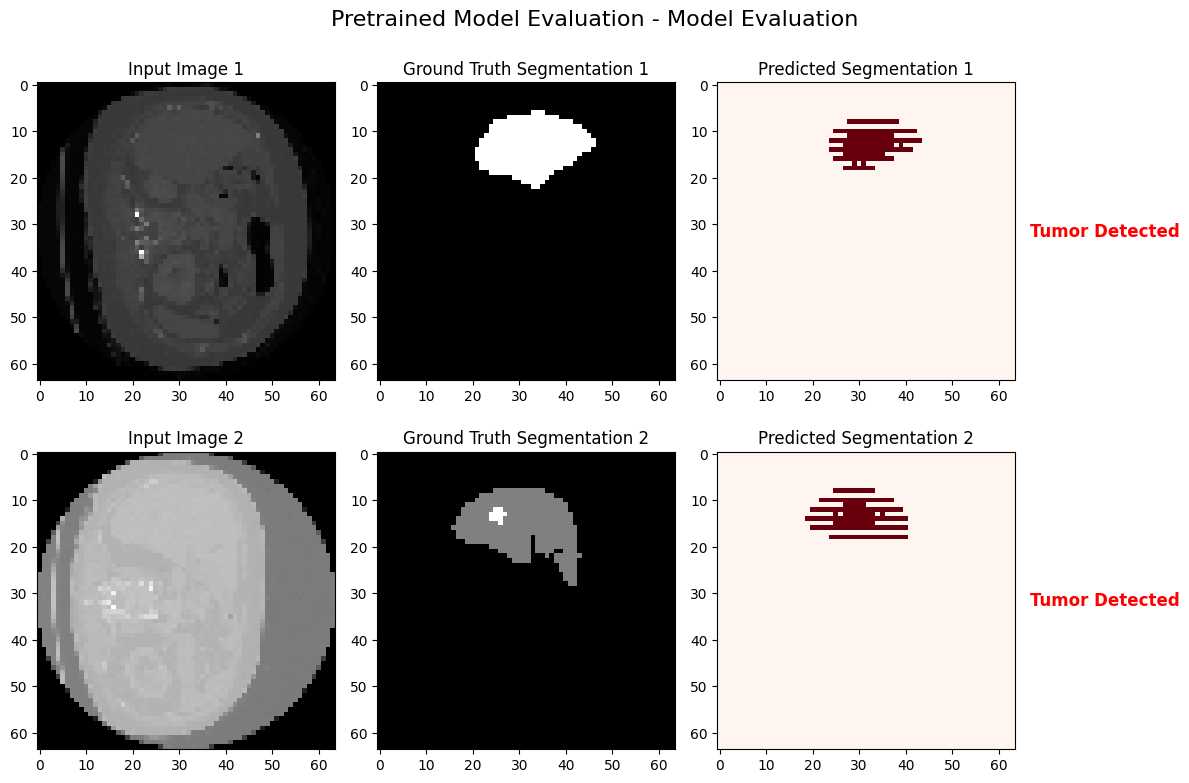

Test Loss: 0.3113, Segmentation Accuracy: 98.00%, Classification Accuracy: 100.00%


In [11]:
model_path = 's4c_model.pth'
#code block to evaluate an already existing model 
if load_pretrained_model(model, model_path):
    print("Testing the loaded model on test set...")
        
    with torch.no_grad():
            model.eval()
            test_running_loss = 0.0
            test_correct_seg = 0
            test_total_seg = 0
            test_correct_class = 0
            test_total_class = 0

            for idx, (test_inputs, test_masks) in enumerate(test_loader):
                test_inputs = test_inputs.unsqueeze(1).to(device)
                test_masks = test_masks.to(device)
                test_seg_output, test_classification_output = model(test_inputs)
                test_masks = test_masks.squeeze(1)

                test_seg_loss = segmentation_loss_fn(test_seg_output, test_masks)
                test_class_target = (test_masks.view(test_masks.size(0), -1).any(dim=1).float()).unsqueeze(1).to(device)
                test_class_loss = classification_loss_fn(test_classification_output, test_class_target)

                test_loss = test_seg_loss + test_class_loss
                test_running_loss += test_loss.item()

                test_pred_seg = torch.argmax(test_seg_output, dim=1)
                test_correct_seg += (test_pred_seg == test_masks).sum().item()
                test_total_seg += test_masks.numel()

                test_correct_class += ((test_classification_output > 0.5).float() == test_class_target).sum().item()
                test_total_class += test_class_target.size(0)

                if idx == 0: 
                    visualize_outputs(test_inputs.cpu(), test_seg_output.cpu(), test_classification_output.cpu(), test_masks.cpu(), epoch="Pretrained Model Evaluation")

            test_epoch_loss = test_running_loss / len(test_loader)
            test_seg_accuracy = test_correct_seg / test_total_seg * 100
            test_class_accuracy = test_correct_class / test_total_class * 100
            print(f'Test Loss: {test_epoch_loss:.4f}, Segmentation Accuracy: {test_seg_accuracy:.2f}%, Classification Accuracy: {test_class_accuracy:.2f}%')
else:
    print("Training the model from scratch...")
    model = train_model(model, train_loader, test_loader, segmentation_loss_fn, classification_loss_fn, optimizer, scheduler, num_epochs=2)


In [9]:
#saving the model 
torch.save(model.state_dict(), 's4c_model.pth')
